In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [177]:
import matplotlib as mpl

plt.rcParams['font.family']='NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [178]:
train=pd.read_csv('235745_parking_data/train.csv')
test=pd.read_csv('235745_parking_data/test.csv')
info=pd.read_csv('235745_parking_data/age_gender_info.csv')
submit=pd.read_csv('235745_parking_data/sample_submission.csv')

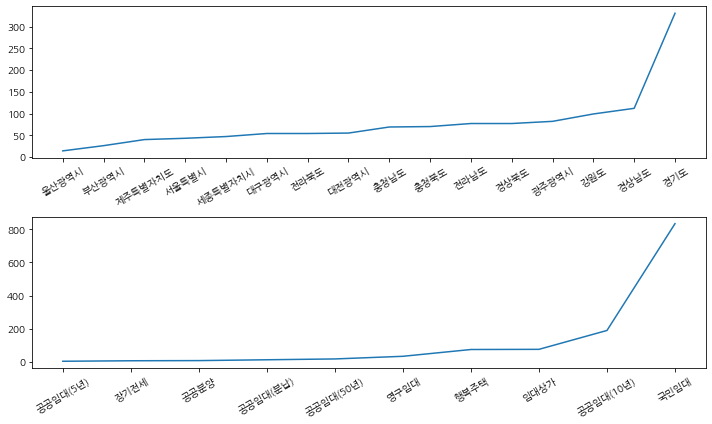

In [179]:
## 처리해야 할 문제 

## 1. 단지코드는 겹치는 그 안에서 전용면적이나 임대보증금 임대료가 차이가 난다.
## 문제는 등록차량수느 같은데 그 안에서 다른 경우가 있다. 등록차량수를 예측할 때 단지코드를 기준으로 병합이 되어있어야 한다.

## 2. 결측값이 있다. 임대보증금이 0이면 임대료도 0이다. 지하철이나 버스는 0으로 채우기.

## 3. 다지내주차면수 > 등록차량수 vs 단지내주차면수 < 등록차량수 규칙을 찾아보는건 어떤가
## 대부분 등록차량수가 많고, 특히 아파트 국민임대에서 모든 차량이 필요로 한다.

df=train.loc[(train['단지내주차면수']<train['등록차량수'])]['지역'].value_counts().sort_values()
df2=train.loc[(train['단지내주차면수']<train['등록차량수'])]['공급유형'].value_counts().sort_values()

fig,ax=plt.subplots(2,1,figsize=(10,6))

ax[0].plot(df)
ax[0].set_xticklabels(df.index,rotation=30)

ax[1].plot(df2)
ax[1].set_xticklabels(df2.index,rotation=30)

plt.tight_layout()
plt.show()

## 4. 변하는 수 : 전용면적,임대료,임대료보증금(-도 포함되어있다. 그래서 아파트만 하려고한다.), 중요한건 이게 아닌거 같다. 오버피팅을 오히려 만든다. 
## 변하지 않는 수 : 단지코드(train과 test의 단지코드가 차이가난다. 즉, 단지코드의 피쳐로 예측해야한다.),
## 총 세대수, 등록차량수, 지역,단지내 주차면수 

## 5. 규칙1
## 같은 단지코드내의 상가와 아파트는 등록차량수를 공유한다. 

## 6. 규칙2
## 상가는 보통 임대료값이 안나와있다. 아파트하고 공공임대이런건 나와있다. 

gubuncode=[]
for code in train['단지코드'].unique():
    df=train[train['단지코드']==code]
    if df['임대건물구분'].nunique()>=2:
        gubuncode.append(code)
        
# gubuncode2=[]
# for code in gubuncode:
#     df=train[train['단지코드']==code]
#     if df['등록차량수'].nunique()>=2:
#         gubuncode2.append(code)

In [180]:
## 진행방향.

## 1. 데이터 이상
## 오류 직접 수정? x
## 토크에도 나온. 총세대수와 전용면적별세대수의 합과 다른 코드들이 있다. 공가수를 합해도 이상하다. 그냥 안고 간다.
## 결측값 버스,지하철은 0으로 없는 임대료는 상가 제외.
## 그냥 회귀식을 사용하여 오버피팅을 하겠다. 

## 2. 

In [181]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)']=train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
train['도보 10분거리 내 버스정류장 수']=train['도보 10분거리 내 버스정류장 수'].fillna(0)

test['도보 10분거리 내 지하철역 수(환승노선 수 반영)']=test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

In [182]:
train=train.drop_duplicates()
test=test.drop_duplicates()

train=train.dropna()
test=test.dropna()

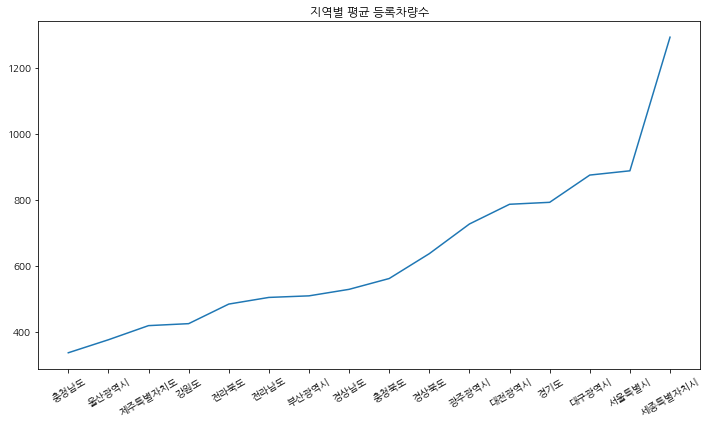

In [183]:
## 7. 지역별 등록차량수

df=train[['지역','등록차량수']].groupby('지역').mean().sort_values(by='등록차량수')

fig,ax=plt.subplots(1,1,figsize=(10,6))

ax.plot(df)
ax.set_xticklabels(df.index,rotation=30)

plt.title('지역별 평균 등록차량수')

plt.tight_layout()
plt.show()

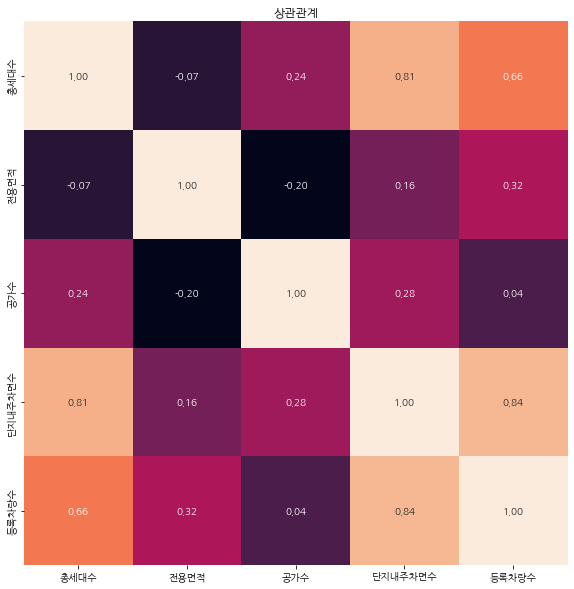

In [184]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

sns.heatmap(train[['총세대수','전용면적','공가수','단지내주차면수','등록차량수']].corr(),fmt='.2f',annot=True,square=True,ax=ax,cbar=False)

plt.title('상관관계')

plt.yticks(va='center')
plt.show()

In [185]:
## 숫자로만 1차

## std면적이 null값이 경우가 있다. 하나의 케이스밖에 없는경우 둘이 나눠서 ? 

train=train[['단지코드','총세대수','전용면적','단지내주차면수','등록차량수']]
test=test[['단지코드','총세대수','전용면적','단지내주차면수']]

In [186]:
# train=pd.merge(train,info,on='지역')
# test=pd.merge(test,info,on='지역')

In [187]:
mean_area=pd.Series(train.groupby('단지코드')['전용면적'].mean(),name='mean면적')
median_area=pd.Series(train.groupby('단지코드')['전용면적'].median(),name='med면적')
std_area=pd.Series(train.groupby('단지코드')['전용면적'].std(),name='std면적')
min_area=pd.Series(train.groupby('단지코드')['전용면적'].min(),name='min면적')
max_area=pd.Series(train.groupby('단지코드')['전용면적'].max(),name='max면적')
sum_area=pd.Series(train.groupby('단지코드')['전용면적'].sum(),name='sum면적')

ts_mean_area=pd.Series(test.groupby('단지코드')['전용면적'].mean(),name='mean면적')
ts_median_area=pd.Series(test.groupby('단지코드')['전용면적'].median(),name='med면적')
ts_std_area=pd.Series(test.groupby('단지코드')['전용면적'].std(),name='std면적')
ts_min_area=pd.Series(test.groupby('단지코드')['전용면적'].min(),name='min면적')
ts_max_area=pd.Series(test.groupby('단지코드')['전용면적'].max(),name='max면적')
ts_sum_area=pd.Series(test.groupby('단지코드')['전용면적'].sum(),name='sum면적')

In [188]:
train=pd.merge(train,mean_area,on='단지코드').\
merge(median_area,on='단지코드').\
merge(std_area,on='단지코드').\
merge(min_area,on='단지코드').\
merge(max_area,on='단지코드').\
merge(sum_area,on='단지코드')

test=pd.merge(test,ts_mean_area,on='단지코드').\
merge(ts_median_area,on='단지코드').\
merge(ts_std_area,on='단지코드').\
merge(ts_min_area,on='단지코드').\
merge(ts_max_area,on='단지코드').\
merge(ts_sum_area,on='단지코드')

In [191]:
train=train.drop(['전용면적','단지코드'],axis=1).drop_duplicates().reset_index(drop=True)
test=test.drop(['전용면적','단지코드'],axis=1).drop_duplicates().reset_index(drop=True)

train=train.fillna(-999)

In [197]:
from sklearn.linear_model import LinearRegression

model=LinearRegression(normalize=False)

model.fit(train.drop('등록차량수',axis=1),train['등록차량수'])

pred=model.predict(test)

In [199]:
submit['num']=pred
submit.head()

,code,num
0,C1072,672.465164
1,C1128,1116.914629
2,C1456,560.690560
3,C1840,528.424960
4,C1332,1028.124496


In [203]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators=1000,random_state=71,criterion='mae',verbose=100,n_jobs=-1)

model.fit(train.drop('등록차량수',axis=1),train['등록차량수'])

pred=model.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 6 of 1000[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s

building tree 7 of 1000
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
building tree 8 of 1000
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
building tree 9 of 1000
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
building tree 10 of 1000
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.2s
building tree 11 of 1000
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.2s
building tree 12 of 1000
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
building tree 13 of 1000
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
building tree 14 of 1000
[Parallel(n_jobs=-1)

building tree 106 of 1000
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
building tree 107 of 1000
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:    2.4s
building tree 108 of 1000[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.4s

building tree 109 of 1000[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    2.4s

building tree 110 of 1000
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    2.5s
building tree 111 of 1000
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:    2.5s
building tree 112 of 1000
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.5s
building tree 113 of 1000
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    2.5s
building tree 114 of 1000[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    2.5s

building tree 115 of 1000[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    2.6s

building tree 116 of 1000[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s

building tree 117 of 1000[Parall

building tree 201 of 1000[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    4.4s

building tree 202 of 1000[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    4.4s

building tree 203 of 1000[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:    4.4s

building tree 204 of 1000
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    4.4s
building tree 205 of 1000[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    4.4s

building tree 206 of 1000
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    4.5s
building tree 207 of 1000[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:    4.5s

building tree 208 of 1000[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    4.5s

building tree 209 of 1000
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    4.5s
building tree 210 of 1000[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    4.5s

building tree 211 of 1000[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    4.6s

building tree 212 of 1000[Parall

building tree 299 of 1000[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:    6.4s

building tree 300 of 1000[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    6.4s

building tree 301 of 1000
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    6.4s
building tree 302 of 1000[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    6.4s

building tree 303 of 1000
[Parallel(n_jobs=-1)]: Done 299 tasks      | elapsed:    6.5s
building tree 304 of 1000[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    6.5s

building tree 305 of 1000
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:    6.5s
building tree 306 of 1000
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:    6.5s
building tree 307 of 1000
[Parallel(n_jobs=-1)]: Done 303 tasks      | elapsed:    6.5s
building tree 308 of 1000
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    6.5s
building tree 309 of 1000
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
building tree 310 of 1000
[Paral

building tree 394 of 1000
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    8.3s
building tree 395 of 1000[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed:    8.3s

building tree 396 of 1000[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    8.3s

building tree 397 of 1000
[Parallel(n_jobs=-1)]: Done 393 tasks      | elapsed:    8.3s
building tree 398 of 1000[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    8.4s

building tree 399 of 1000
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed:    8.4s
building tree 400 of 1000
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    8.4s
building tree 401 of 1000[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:    8.5s

building tree 402 of 1000
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:    8.5s
building tree 403 of 1000
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:    8.5s
building tree 404 of 1000
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    8.5s
building tree 405 of 1000[Parall

building tree 489 of 1000
[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed:   10.4s
building tree 490 of 1000
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   10.4s
building tree 491 of 1000
[Parallel(n_jobs=-1)]: Done 487 tasks      | elapsed:   10.4s
building tree 492 of 1000
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   10.4s
building tree 493 of 1000
[Parallel(n_jobs=-1)]: Done 489 tasks      | elapsed:   10.5s
building tree 494 of 1000[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   10.5s

building tree 495 of 1000[Parallel(n_jobs=-1)]: Done 491 tasks      | elapsed:   10.5s

building tree 496 of 1000[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   10.5s

building tree 497 of 1000[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed:   10.6s

building tree 498 of 1000[Parallel(n_jobs=-1)]: Done 494 tasks      | elapsed:   10.6s

building tree 499 of 1000[Parallel(n_jobs=-1)]: Done 495 tasks      | elapsed:   10.6s

building tree 500 of 1000
[Paral

building tree 585 of 1000
[Parallel(n_jobs=-1)]: Done 581 tasks      | elapsed:   12.3s
building tree 586 of 1000[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:   12.3s

building tree 587 of 1000
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:   12.3s
building tree 588 of 1000
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   12.3s
building tree 589 of 1000
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed:   12.4s
building tree 590 of 1000
[Parallel(n_jobs=-1)]: Done 586 tasks      | elapsed:   12.4s
building tree 591 of 1000
[Parallel(n_jobs=-1)]: Done 587 tasks      | elapsed:   12.4s
building tree 592 of 1000[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.4s

building tree 593 of 1000[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   12.5s

building tree 594 of 1000[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:   12.5s

building tree 595 of 1000
[Parallel(n_jobs=-1)]: Done 591 tasks      | elapsed:   12.5s
building tree 596 of 1000[Parall

building tree 681 of 1000[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:   14.2s

building tree 682 of 1000
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:   14.2s
building tree 683 of 1000
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:   14.2s
building tree 684 of 1000
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   14.3s
building tree 685 of 1000
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:   14.3s
building tree 686 of 1000
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   14.3s
building tree 687 of 1000
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:   14.3s
building tree 688 of 1000
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:   14.3s
building tree 689 of 1000
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   14.4s
building tree 690 of 1000
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:   14.4s
building tree 691 of 1000
[Parallel(n_jobs=-1)]: Done 687 tasks      | elapsed:   14.4s
building tree 692 of 1000
[Paral

building tree 778 of 1000[Parallel(n_jobs=-1)]: Done 774 tasks      | elapsed:   16.2s

building tree 779 of 1000[Parallel(n_jobs=-1)]: Done 775 tasks      | elapsed:   16.2s

building tree 780 of 1000
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   16.2s
building tree 781 of 1000[Parallel(n_jobs=-1)]: Done 777 tasks      | elapsed:   16.2s

building tree 782 of 1000[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:   16.3s

building tree 783 of 1000
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:   16.3s
building tree 784 of 1000[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   16.3s

building tree 785 of 1000
[Parallel(n_jobs=-1)]: Done 781 tasks      | elapsed:   16.3s
building tree 786 of 1000[Parallel(n_jobs=-1)]: Done 782 tasks      | elapsed:   16.3s

building tree 787 of 1000
[Parallel(n_jobs=-1)]: Done 783 tasks      | elapsed:   16.3s
building tree 788 of 1000
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   16.4s
building tree 789 of 1000
[Paral

building tree 881 of 1000
[Parallel(n_jobs=-1)]: Done 877 tasks      | elapsed:   18.1s
building tree 882 of 1000
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:   18.1s
building tree 883 of 1000
[Parallel(n_jobs=-1)]: Done 879 tasks      | elapsed:   18.2s
building tree 884 of 1000
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed:   18.2s
building tree 885 of 1000
[Parallel(n_jobs=-1)]: Done 881 tasks      | elapsed:   18.2s
building tree 886 of 1000
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed:   18.2s
building tree 887 of 1000[Parallel(n_jobs=-1)]: Done 883 tasks      | elapsed:   18.2s

building tree 888 of 1000[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:   18.2s

building tree 889 of 1000
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:   18.3s
building tree 890 of 1000
[Parallel(n_jobs=-1)]: Done 886 tasks      | elapsed:   18.3s
building tree 891 of 1000[Parallel(n_jobs=-1)]: Done 887 tasks      | elapsed:   18.3s

building tree 892 of 1000
[Paral

building tree 975 of 1000
[Parallel(n_jobs=-1)]: Done 971 tasks      | elapsed:   20.1s
building tree 976 of 1000
[Parallel(n_jobs=-1)]: Done 972 tasks      | elapsed:   20.1s
building tree 977 of 1000[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:   20.1s

building tree 978 of 1000
[Parallel(n_jobs=-1)]: Done 974 tasks      | elapsed:   20.1s
building tree 979 of 1000[Parallel(n_jobs=-1)]: Done 975 tasks      | elapsed:   20.1s

building tree 980 of 1000
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   20.2s
building tree 981 of 1000
[Parallel(n_jobs=-1)]: Done 977 tasks      | elapsed:   20.2s
building tree 982 of 1000
[Parallel(n_jobs=-1)]: Done 978 tasks      | elapsed:   20.2s
building tree 983 of 1000[Parallel(n_jobs=-1)]: Done 979 tasks      | elapsed:   20.2s

building tree 984 of 1000
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   20.2s
building tree 985 of 1000[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   20.3s

building tree 986 of 1000
[Paral

[Parallel(n_jobs=4)]: Done 317 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 318 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 319 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 321 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 323 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 324 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 325 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 326 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 327 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 329 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 331 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 595 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 596 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 597 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 598 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 599 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 601 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 602 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 603 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 604 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 605 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 606 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 607 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 608 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 609 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 610 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 861 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 862 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 863 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 864 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 865 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 866 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 867 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 868 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 869 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 870 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 871 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 872 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 873 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 875 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Do

In [205]:
submit['num']=pred
submit.head()

,code,num
0,C1072,693.7545
1,C1128,1241.0700
2,C1456,554.7560
3,C1840,585.6840
4,C1332,1139.0210


In [206]:
submit.to_csv('20210712_rfr.csv',index=False)